In [1]:
import madmom

In [2]:
madmom.__version__

'0.17.dev0'

In [3]:
!pip install git+https://github.com/CPJKU/madmom.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/CPJKU/madmom.git to /tmp/pip-req-build-o9ph_89c
  Running command git clone -q https://github.com/CPJKU/madmom.git /tmp/pip-req-build-o9ph_89c
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for madmom: filename=madmom-0.17.dev0-cp37-cp37m-linux_x86_64.whl size=25514381 sha256=557648c947d1f6efa9134505b7b8fa623b29aca9a56119704794373044566d77
  Stored in directory: /tmp/pip-ephem-wheel-cache-9lunuqah/wheels/7e/ea/af/d4b2a0b6be5da7440917d280ba975f40ec192311def6e6d537
Successfully built madmom
  Attempting uninstall: madmom
    Found existing installation: madmom 0.16.1
    Uninstalling madmom-0.16.1:
      Successfully uninstalled madmom-0.16.1


In [3]:
import xmltodict
from urllib.parse import unquote

with open('beats.xml') as f:
    doc = xmltodict.parse(f.read())

data = doc['DJ_PLAYLISTS']['COLLECTION']['TRACK']

data = data[-10:]
churry = []

k = 0

for i in data:
    churry.append({'path': 'Music files/'+unquote(i['@Location']).split('/')[-1],
                  'beats': [],
                  'downbeats': []
                  })

    beat = 60/float(i['@AverageBpm'])

    if isinstance(i['TEMPO'], list):
        for j in range(len(i['TEMPO'])):
            t = float(i['TEMPO'][j]['@Inizio'])
            d = int(i['TEMPO'][j]['@Battito'])
            if j < len(i['TEMPO'])-1:
                u = float(i['TEMPO'][j+1]['@Inizio'])
            else:
                u = float(i['@TotalTime'])
            while t < u:
                if u - t > beat:
                    churry[k]['beats'].append(t)
                    churry[k]['downbeats'].append(d)
                t += beat
                d += 1
                if d == 5:
                    d = 1

    else:
        t = float(i['TEMPO']['@Inizio'])
        d = int(i['TEMPO']['@Battito'])
        u = float(i['@TotalTime'])
        while t < u:
            churry[k]['beats'].append(t)
            churry[k]['downbeats'].append(d)
            t += beat
            d += 1
            if d == 5:
                d = 1
    k += 1

In [4]:
import numpy as np
from pydub import AudioSegment


def load_pydub_audio(path):
  # Load the audio using smart open. It supports streaming large audio files at remote
  # storages such as AWS S3.
    file_obj = open(path, 'rb')
    pydub_audio = AudioSegment.from_file(file_obj)
    return pydub_audio


def load_audio(path, sample_rate=44100, num_channels=1, sample_width=2, normalize=False, dtype='float32'):
    pydub_audio = load_pydub_audio(path)
    # Resample if `sample_rate` is given.
    if sample_rate:
        pydub_audio = pydub_audio.set_frame_rate(sample_rate)
    else:
        sample_rate = pydub_audio.frame_rate
    # Set the number of channel (default: mono)
    pydub_audio = pydub_audio.set_channels(num_channels)
    pydub_audio = pydub_audio.set_sample_width(sample_width)
    # Normalize audio gain (dB) if `normalize` is `True`.
    if normalize:
        # headroom is how close to the maximum volume to boost the signal up to (specified in dB)
        pydub_audio = pydub_audio.normalize(headroom=0.1)
    # Efficient conversion from pydub.AudioSegment to numpy array.
    array_buf = np.frombuffer(pydub_audio.raw_data, dtype=pydub_audio.array_type)
    array_buf = array_buf.reshape(pydub_audio.channels, -1, order='F')
    array_buf = array_buf.squeeze()
    array = array_buf.astype(dtype)
    assert array_buf.dtype == np.int16
    array /= np.iinfo(array_buf.dtype).max
    return array, sample_rate

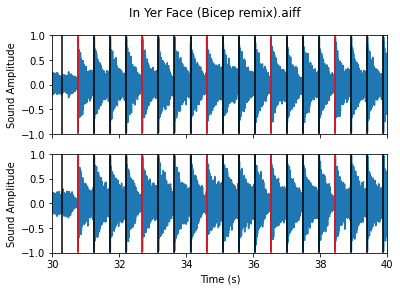

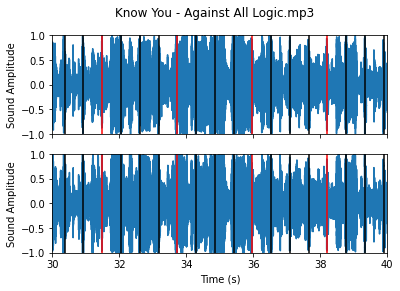

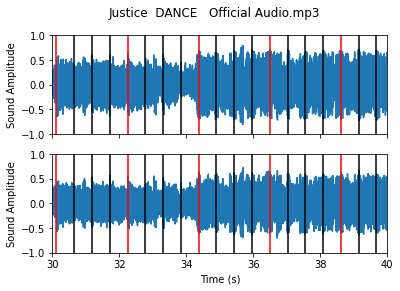

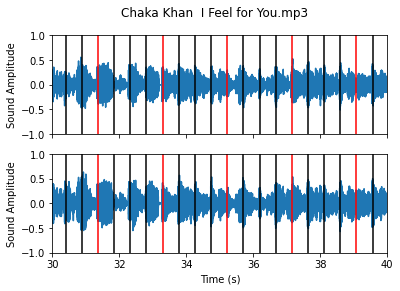

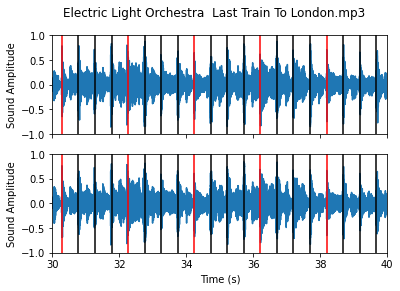

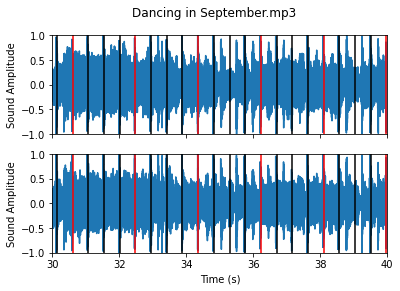

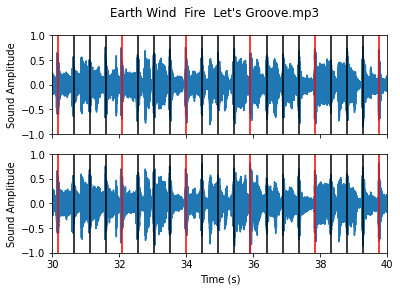

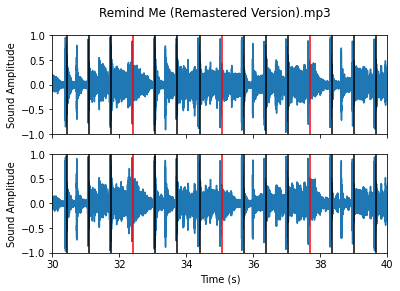

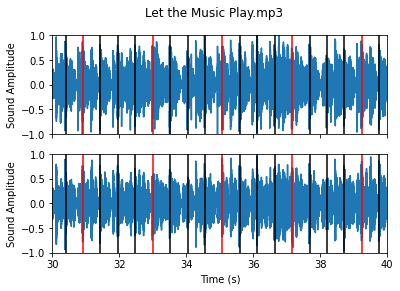

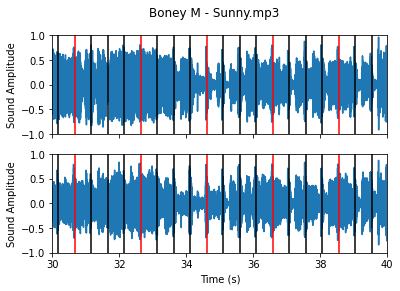

In [5]:
import matplotlib.pyplot as plt
import IPython.display as ipd

arrays = []

for song in churry:
    array, sr = load_audio(song['path'], num_channels=2)
    arrays.append(array)
    
    time = np.arange(0, len(array[0])) / sr

    fig, ax = plt.subplots(2, sharex=True)
    
    ax[0].plot(time,array[0])
    ax[0].set(ylabel='Sound Amplitude', xlim=(30,40), ylim=(-1,1))
    ax[1].plot(time,array[1])
    ax[1].set(xlabel='Time (s)', ylabel='Sound Amplitude', xlim=(30,40), ylim=(-1,1))
    
    for t in range(len(song['beats'])):
        if song['beats'][t] > 30 and song['beats'][t] < 40:
            if song['downbeats'][t] == 1:
                ax[0].vlines(song['beats'][t], -1, 1, colors='red')
                ax[1].vlines(song['beats'][t], -1, 1, colors='red')
            else:
                ax[0].vlines(song['beats'][t], -1, 1, colors='black')
                ax[1].vlines(song['beats'][t], -1, 1, colors='black')
    
    plt.suptitle(song['path'].split('/')[-1])
    plt.show()

In [101]:
import librosa
import librosa.display

def play_reference_audio(song):
    times = np.array(churry[song]['beats'])
    downbeats = np.array(churry[song]['downbeats'])
    downbeat_filter = downbeats == 1
    else_filter = downbeats > 1
    
    downbeatTimes = times[downbeat_filter]
    elseTimes = times[else_filter]
    
    clicks = arrays[song][0]+librosa.clicks(times=downbeatTimes, sr=sr, length=len(arrays[song][0]), click_freq=2000)+librosa.clicks(times=elseTimes,sr=sr, length=len(arrays[song][0]))
    
    return ipd.Audio(clicks[0:441000], rate=sr)
    
play_reference_audio(1)

In [36]:
import madmom
import mir_eval

def beats_downbeats_eval(song):
    audio_path = churry[song]['path']
    act = madmom.features.downbeats.RNNDownBeatProcessor()(audio_path)
    proc = madmom.features.downbeats.DBNDownBeatTrackingProcessor(
      beats_per_bar=4,
      transition_lambda=300,
      observation_lambda=128,
      fps=100,
    )
    beats_and_downbeats = proc(act)

    estimated_beats = beats_and_downbeats[:, 0]
    reference_beats = np.array(churry[song]['beats'])

    estimated_downbeats_filter = beats_and_downbeats[:, 1] == 1
    reference_downbeats_filter = np.array(churry[song]['downbeats']) == 1
    
    estimated_downbeats = estimated_beats[estimated_downbeats_filter]
    reference_downbeats = reference_beats[reference_downbeats_filter]
    
    beats_scores = mir_eval.beat.evaluate(reference_beats, estimated_beats)
    downbeats_scores = mir_eval.beat.evaluate(reference_downbeats, estimated_downbeats)
    
    return beats_scores, downbeats_scores
# 아래 함수 사용해서 성능 측정:
# scores = mir_eval.beat.evaluate(reference_beats, estimated_beats)
# reference_beats: 정답 비트
# estimated_beats: 예측한 비트

In [118]:
song = 1
audio_path = churry[song]['path']
act = madmom.features.downbeats.RNNDownBeatProcessor()(audio_path)
proc = madmom.features.downbeats.DBNDownBeatTrackingProcessor(
  beats_per_bar=4,
  transition_lambda=300,
  observation_lambda=128,
  fps=100,
)
beats_and_downbeats = proc(act)

estimated_beats = beats_and_downbeats[:, 0]
reference_beats = np.array(churry[song]['beats'])

estimated_downbeats_filter = beats_and_downbeats[:, 1] == 1
reference_downbeats_filter = np.array(churry[song]['downbeats']) == 1

estimated_downbeats = estimated_beats[estimated_downbeats_filter]
reference_downbeats = reference_beats[reference_downbeats_filter]

beats_scores = mir_eval.beat.evaluate(reference_beats, estimated_beats)
downbeats_scores = mir_eval.beat.evaluate(reference_downbeats, estimated_downbeats)

In [129]:
act.shape

(26474, 2)

In [84]:
beats_scores, downbeats_scores

(OrderedDict([('F-measure', 0.9989189189189189),
              ('Cemgil', 0.711251148715076),
              ('Cemgil Best Metric Level', 0.711251148715076),
              ('Goto', 1.0),
              ('P-score', 0.9978401727861771),
              ('Correct Metric Level Continuous', 0.9978401727861771),
              ('Correct Metric Level Total', 0.9978401727861771),
              ('Any Metric Level Continuous', 0.9978401727861771),
              ('Any Metric Level Total', 0.9978401727861771),
              ('Information gain', 0.7909219949639538)]),
 OrderedDict([('F-measure', 1.0),
              ('Cemgil', 0.7109894900387167),
              ('Cemgil Best Metric Level', 0.7109894900387167),
              ('Goto', 1.0),
              ('P-score', 1.0),
              ('Correct Metric Level Continuous', 1.0),
              ('Correct Metric Level Total', 1.0),
              ('Any Metric Level Continuous', 1.0),
              ('Any Metric Level Total', 1.0),
              ('Information gain

In [6]:
from __future__ import absolute_import, division, print_function

import sys
import warnings

import numpy as np
import madmom

from madmom.features.beats import threshold_activations
from madmom.features.beats_hmm import (BarStateSpace, BarTransitionModel,
                        GMMPatternTrackingObservationModel,
                        MultiPatternStateSpace,
                        MultiPatternTransitionModel,
                        RNNBeatTrackingObservationModel,
                        RNNDownBeatTrackingObservationModel, )
from madmom.ml.hmm import HiddenMarkovModel
from madmom.processors import ParallelProcessor, Processor, SequentialProcessor
from madmom.utils import string_types

class DownBeatProcessor(SequentialProcessor):
    def __init__(self, **kwargs):
        from functools import partial
        from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
        from madmom.audio.stft import ShortTimeFourierTransformProcessor
        from madmom.audio.spectrogram import (
            FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor,
            SpectrogramDifferenceProcessor)
        from madmom.ml.nn import NeuralNetworkEnsemble
        from madmom.models import DOWNBEATS_BLSTM

        # define pre-processing chain
        sig = SignalProcessor(num_channels=1, sample_rate=44100)
        # process multi-resolution spec&diff in parallel
        multi = ParallelProcessor([])
        frame_sizes = [1024, 2048, 4096]
        num_bands = [3, 6, 12]
        for frame_size, num_bands in zip(frame_sizes, num_bands):
            frames = FramedSignalProcessor(frame_size=frame_size, fps=100)
            stft = ShortTimeFourierTransformProcessor() #FFT Window
            filt = FilteredSpectrogramProcessor(
                num_bands=num_bands, fmin=30, fmax=17000, norm_filters=True)
            spec = LogarithmicSpectrogramProcessor(mul=1, add=1)
            diff = SpectrogramDifferenceProcessor(
                diff_ratio = 0.5, positive_diffs = True, stack_diffs=np.hstack)
            multi.append(SequentialProcessor((frames, stft, filt, spec, diff)))
        pre_processor = SequentialProcessor((sig, multi, np.hstack))
        nn = NeuralNetworkEnsemble.load(DOWNBEATS_BLSTM, **kwargs)
        act = partial(np.delete, obj=0, axis=1)
        # instantiate a SequentialProcessor
        super(DownBeatProcessor, self).__init__((pre_processor, nn, act))

In [33]:
?zip

Init signature: zip(self, /, *args, **kwargs)
Docstring:     
zip(*iterables) --> zip object

Return a zip object whose .__next__() method returns a tuple where
the i-th element comes from the i-th iterable argument.  The .__next__()
method continues until the shortest iterable in the argument sequence
is exhausted and then it raises StopIteration.
Type:           type
Subclasses:     


In [34]:
list(zip([1, 2], [3, 4]))

[(1, 3), (2, 4)]

In [8]:
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import (
    FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor,
    SpectrogramDifferenceProcessor)

In [177]:
sig = SignalProcessor(num_channels=1, sample_rate=44100, dtype='float32')(churry[1]['path'])

In [182]:
sig

Signal([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        -3.5136222e-06,  3.0931392e-06,  9.1241532e-07], dtype=float32)

In [179]:
frames = FramedSignalProcessor(frame_size=4096, fps=100)(sig)

In [199]:
spec.shape, spec

((26474, 91),
 LogarithmicSpectrogram([[1.41314405e-04, 1.48146020e-04, 1.42660021e-04,
                          ..., 8.69759879e-06, 7.86926375e-06,
                          8.85291138e-06],
                         [6.55662385e-04, 7.43171200e-04, 8.26941920e-04,
                          ..., 3.85166131e-05, 3.87236832e-05,
                          3.42716703e-05],
                         [1.14435935e-03, 1.62126275e-03, 1.93763652e-03,
                          ..., 9.52499176e-05, 9.99083422e-05,
                          7.38722738e-05],
                         ...,
                         [7.82609265e-03, 1.26455640e-02, 1.27530126e-02,
                          ..., 2.42794282e-04, 2.24787334e-04,
                          9.71132977e-05],
                         [2.78801098e-03, 1.09849097e-02, 1.59686040e-02,
                          ..., 2.18474393e-04, 2.11643870e-04,
                          1.00374185e-04],
                         [1.52031099e-03, 7.47210206e-03

In [144]:
stft = ShortTimeFourierTransformProcessor()(frames)
filt = FilteredSpectrogramProcessor(num_bands=12, fmin=30, fmax=17000, norm_filters=True)(stft)
spec = LogarithmicSpectrogramProcessor(mul=1, add=1)(filt)
diff = SpectrogramDifferenceProcessor(diff_ratio = 0.5, positive_diffs = True, stack_diffs=np.hstack)(spec)

In [230]:
!pip install git+https://github.com/librosa/librosa.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/librosa/librosa.git to /tmp/pip-req-build-b2xtpox4
  Running command git clone -q https://github.com/librosa/librosa.git /tmp/pip-req-build-b2xtpox4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for librosa: filename=librosa-0.9.0-py3-none-any.whl size=211721 sha256=d7dd205037c3682ab3b7d46710d02332e07e6c6bcb9f469eb2bad0e4d35467c9
  Stored in directory: /tmp/pip-ephem-wheel-cache-nccrsdmx/wheels/d2/c9/34/4bce6d91250eff2554c870a42a64aa3b152a69fa36bb96146f
Successfully built librosa
  Attempting uninstall: librosa
    Found existing installation: librosa 0.8.1
    Uninstalling librosa-0.8.1:
      Successfully uninstalled librosa-0.8.1


In [234]:
librosa.__version__

'0.8.1'

In [7]:
import librosa.display
print(spec.T.shape)
librosa.display.specshow(spec.T, y_axis='log', x_axis='time')

NameError: name 'spec' is not defined

In [132]:
stft.shape, filt.shape, spec.shape, diff.shape

((26474, 512), (26474, 69), (26474, 69), (26474, 138))

In [157]:
spec.shape

(26474, 91)

In [158]:
spec0.shape

(100, 91)

In [3]:
!pip install tensorboard

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 5.8 MB 15.0 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 54.0 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 57.5 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 56.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.1 MB 51.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 49.3 MB/s eta 0:00:01
     |████████████████████████████████| 289 kB 52.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 52.8 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 84.1 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 22.5 MB/s eta 0:00:01
     |████████████████████████████████| 151 kB 87.3 MB/s eta 0:00:01


In [9]:
import librosa
%time
print(librosa.stft)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs
<function stft at 0x7f6adc0e1440>


In [10]:
%run hi

['.bash_logout', '.bashrc', '.profile', 'beats.xml', '.jupyter', '.ssh', '.config', '.nv', 'data', '.pycharm_helpers', '.local', '.cache', 'Spectrogram.ipynb', 'torch practice.ipynb', 'main.py', 'hi.py', '.ipython', 'Waveform.ipynb', '.conda', '.ipynb_checkpoints', '.viminfo', '.bash_history', 'Music files', 'venv', 'Untitled.ipynb', '.sudo_as_admin_successful', 'temp.ipynb', '.empty', 'id_ed25519.pub']
